In [1]:
# Cargamos datos
import Loading_data 

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad


,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Curados,Casos excluidos curados,Proporcion Curados / Casos,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,
2020-03-27,Madrid,19243,2077,-492,0.107935,2412,322,57,0.133499,5044,14199,0.262121,1312,13580
2020-03-26,Madrid,17166,2569,324,0.149656,2090,265,-25,0.126794,3882,13284,0.226145,1221,12440
2020-03-25,Madrid,14597,2245,468,0.153799,1825,290,18,0.158904,3031,11566,0.207645,1150,11153
2020-03-24,Madrid,12352,1777,904,0.143863,1535,272,30,0.177199,2291,10061,0.185476,1050,10443
2020-03-23,Madrid,10575,873,92,0.082553,1263,242,25,0.191607,2063,8512,0.195083,942,9561
2020-03-22,Madrid,9702,781,-975,0.080499,1021,217,41,0.212537,0,9702,0.000000,834,8441
2020-03-21,Madrid,8921,1756,1368,0.196839,804,176,46,0.218905,0,8921,0.000000,767,7388
2020-03-20,Madrid,7165,388,-752,0.054152,628,130,22,0.207006,0,7165,0.000000,678,0
2020-03-19,Madrid,6777,1140,374,0.168216,498,108,73,0.216867,0,6777,0.000000,590,0


,Fallecidos hoy variacion respecto ayer
Fecha,
2020-03-27,57
2020-03-26,-25
2020-03-25,18
2020-03-24,30
2020-03-23,25
2020-03-22,41
2020-03-21,46
2020-03-20,22
2020-03-19,73


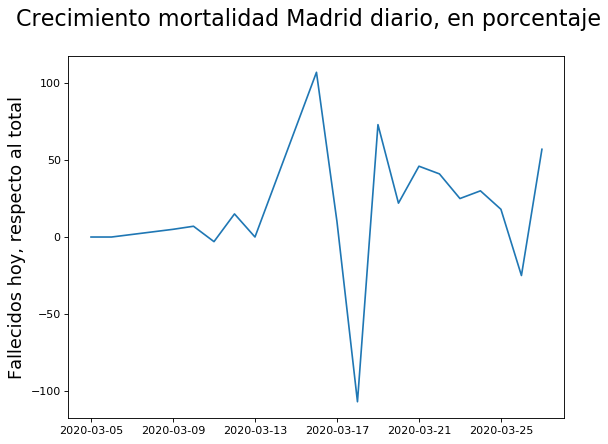

In [2]:
# Grafica
from IPython.display import display, HTML
import pandas as pd

from matplotlib import pyplot as plt    



fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot( comunidad['Fallecidos hoy variacion respecto ayer'])
fig.suptitle('Crecimiento mortalidad '+COMUNIDAD_A_CONSIDERAR+' diario, en porcentaje', fontsize=20)
plt.ylabel('Fallecidos hoy, respecto al total', fontsize=16)

display(HTML(pd.DataFrame(comunidad['Fallecidos hoy variacion respecto ayer']).to_html()))


,Fallecidos hoy absoluto
Fecha,
2020-03-27,322
2020-03-26,265
2020-03-25,290
2020-03-24,272
2020-03-23,242
2020-03-22,217
2020-03-21,176
2020-03-20,130
2020-03-19,108


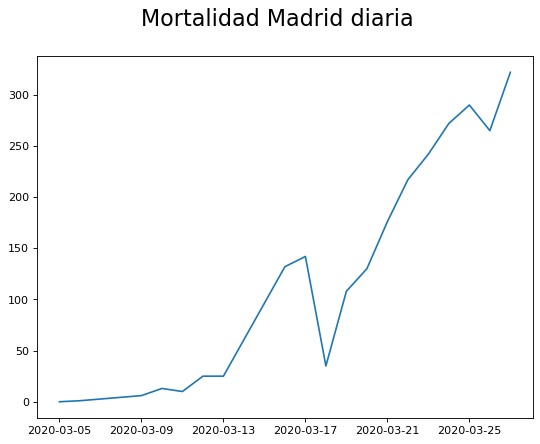

In [3]:
from IPython.display import display, HTML
import pandas as pd
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(comunidad['Fallecidos hoy absoluto']) 
fig.suptitle('Mortalidad '+COMUNIDAD_A_CONSIDERAR+' diaria', fontsize=20)


display(HTML(pd.DataFrame(comunidad['Fallecidos hoy absoluto']).to_html()))



In [4]:
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()


In [5]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos):
    array = []
    for ca in COMUNIDADES: 
        comunidad = Loading_data.Get_Comunidad(ca).head(1)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [6]:
def Print_Two_Cordinates_CCAA(df):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    return plt



In [7]:
from IPython.display import display, HTML


def Comparar_Dos_Dimenciones(Atributos ):
    df = Get_Dimensions_All_CCAA(Atributos)
    plt = Print_Two_Cordinates_CCAA(df)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.sort_values(by=[df.columns[1],df.columns[2]]).to_html()))
    return 

 

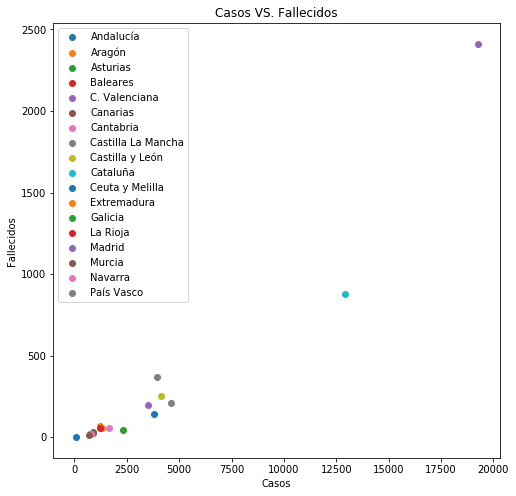

Total: Casos 64059
Total: Fallecidos 4858


,Lugar,Casos,Fallecidos
9,Ceuta y Melilla,59,1
14,Murcia,714,15
3,Baleares,755,22
5,Cantabria,810,21
4,Canarias,878,27
2,Asturias,900,29
11,Extremadura,1231,69
17,La Rioja,1236,55
1,Aragón,1338,58
15,Navarra,1641,58


In [8]:

Comparar_Dos_Dimenciones(['Casos', 'Fallecidos'] )   



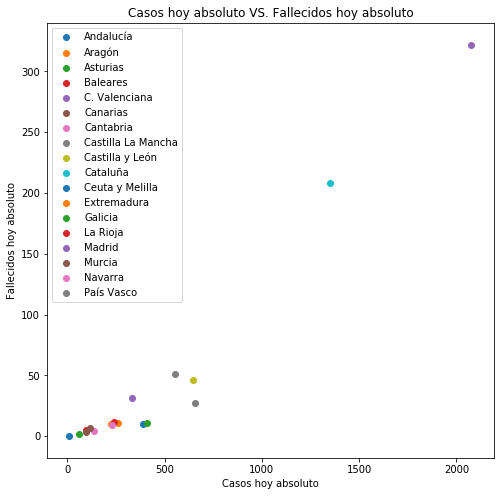

Total: Casos hoy absoluto 7871
Total: Fallecidos hoy absoluto 769


,Lugar,Casos hoy absoluto,Fallecidos hoy absoluto
9,Ceuta y Melilla,10,0
2,Asturias,59,2
4,Canarias,94,3
3,Baleares,95,5
14,Murcia,118,7
5,Cantabria,139,4
1,Aragón,222,10
15,Navarra,230,9
17,La Rioja,241,12
11,Extremadura,262,11


In [9]:
Comparar_Dos_Dimenciones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'])

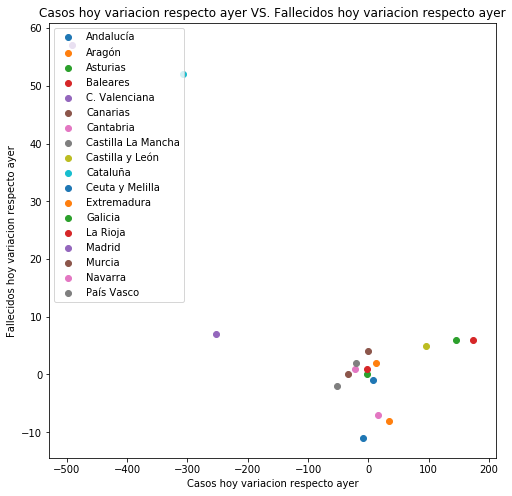

Total: Casos hoy variacion respecto ayer -707
Total: Fallecidos hoy variacion respecto ayer 114


,Lugar,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
13,Madrid,-492,57
8,Cataluña,-307,52
10,C. Valenciana,-252,7
6,Castilla La Mancha,-52,-2
4,Canarias,-33,0
5,Cantabria,-22,1
16,País Vasco,-20,2
0,Andalucía,-9,-11
2,Asturias,-3,0
3,Baleares,-3,1


In [10]:
Comparar_Dos_Dimenciones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])


In [11]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension):
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = df.sort_values(by='Fecha')
        df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]

        dimension_df[ca] = df[Dimension]
        #print ('Get_Dimension_CCAA' + Dimension + str(df.shape) )
    #print (dimension_df)
    return dimension_df 


In [12]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

def Comparar_Comunidades(Dimension):
    df = Get_Dimension_CCAA(Dimension)
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)
    
    fig.suptitle('Comparativa de: '+Dimension+', igualando los dias', fontsize=20)
    plt.show()

    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 


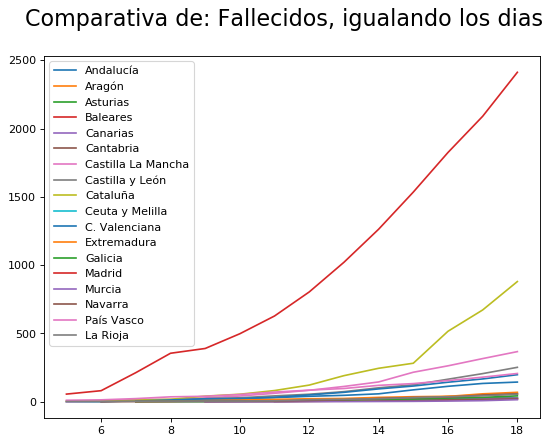

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
6,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
7,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
8,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
9,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
10,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
11,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
12,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
13,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18
14,58,32.0,12.0,10.0,11.0,6.0,145,102.0,245,NaN,94.0,18.0,18.0,1263,2.0,24.0,120,22


In [13]:
Comparar_Comunidades("Fallecidos")

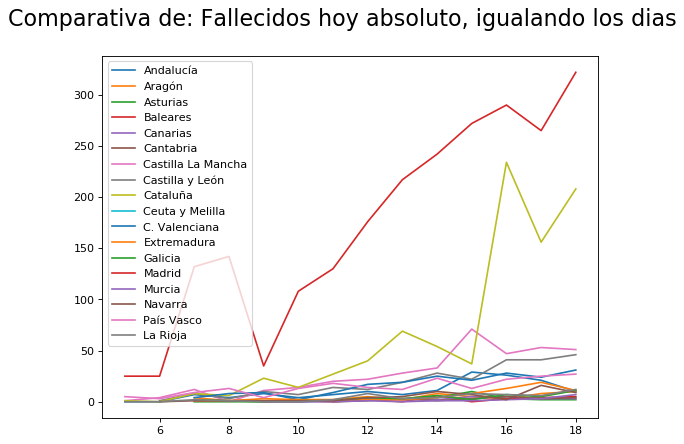

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
6,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
7,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
8,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
9,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
10,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
11,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
12,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
13,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3
14,11,8.0,4.0,6.0,2.0,1.0,33,28.0,54,NaN,25.0,4.0,6.0,242,1.0,10.0,23,4


In [14]:
Comparar_Comunidades("Fallecidos hoy absoluto") 

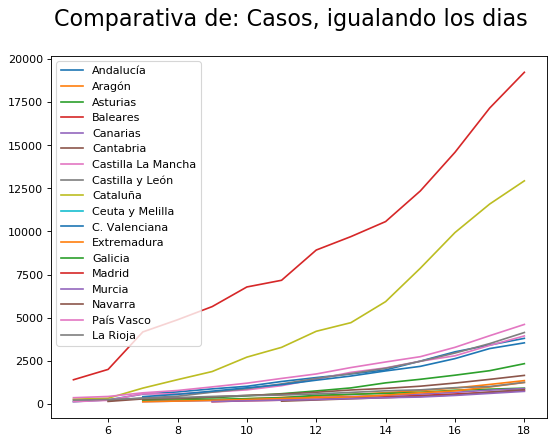

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
6,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
7,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
8,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
9,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
10,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
11,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
12,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
13,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654
14,1961,638.0,594.0,400.0,481.0,347.0,2078,2055.0,5925,NaN,1901.0,493.0,1208.0,10575,345.0,886.0,2421,747


In [15]:
Comparar_Comunidades("Casos") 

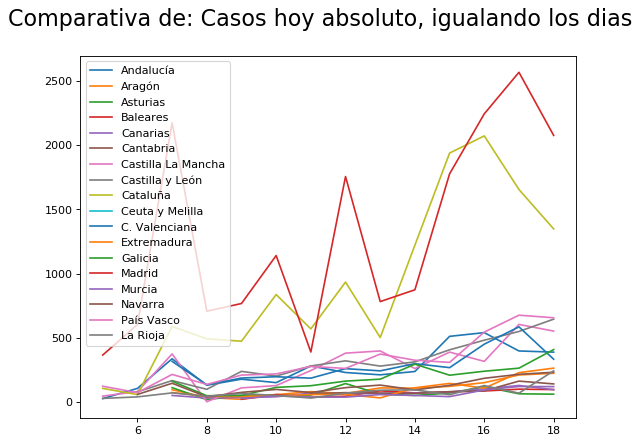

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,25,NaN,NaN,NaN,NaN,NaN,44,NaN,104,NaN,NaN,NaN,NaN,364,NaN,NaN,121,26
6,104,NaN,NaN,NaN,NaN,NaN,79,77.0,56,NaN,NaN,NaN,NaN,602,NaN,57.0,71,38
7,335,94.0,110.0,NaN,49.0,NaN,373,165.0,587,NaN,315.0,72.0,160.0,2175,NaN,144.0,213,69
8,129,33.0,16.0,NaN,29.0,NaN,0,97.0,491,NaN,132.0,42.0,47.0,706,NaN,39.0,135,43
9,176,19.0,49.0,20.0,33.0,NaN,108,237.0,472,NaN,185.0,41.0,49.0,766,25.0,73.0,208,64
10,149,55.0,50.0,57.0,39.0,NaN,126,200.0,836,NaN,195.0,47.0,112.0,1140,45.0,96.0,217,49
11,279,79.0,52.0,34.0,67.0,61.0,243,279.0,568,NaN,184.0,56.0,125.0,388,37.0,72.0,275,29
12,228,64.0,142.0,43.0,61.0,71.0,379,319.0,933,NaN,258.0,57.0,161.0,1756,36.0,110.0,260,67
13,210,108.0,59.0,85.0,66.0,67.0,396,278.0,501,NaN,241.0,30.0,176.0,781,56.0,130.0,372,90
14,236,106.0,49.0,69.0,67.0,65.0,259,311.0,1221,NaN,297.0,109.0,293.0,873,49.0,92.0,324,93


In [16]:
Comparar_Comunidades("Casos hoy absoluto")


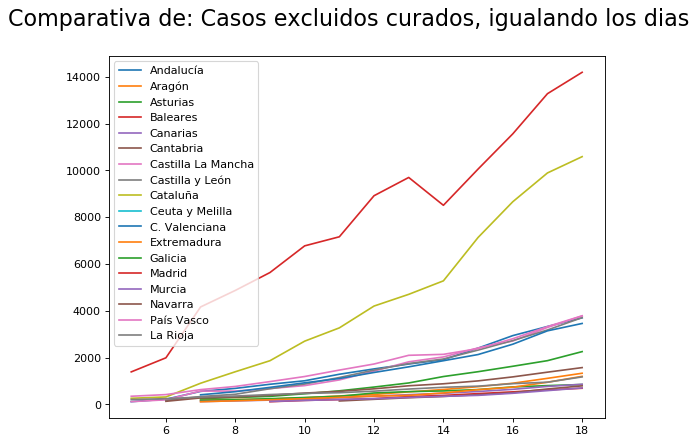

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
6,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
7,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
8,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
9,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
10,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
11,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
12,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
13,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654
14,1911,635.0,573.0,382.0,474.0,336.0,2027,1938.0,5281,NaN,1865.0,487.0,1189.0,8512,344.0,879.0,2138,729


In [17]:
Comparar_Comunidades("Casos excluidos curados")


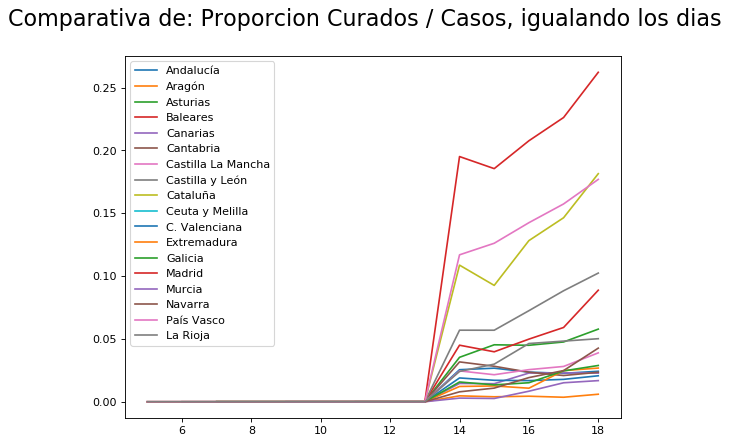

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
6,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.025497,0.004702,0.035354,0.045000,0.014553,0.031700,0.024543,0.056934,0.108692,NaN,0.018937,0.012170,0.015728,0.195083,0.002899,0.007901,0.116894,0.024096


In [18]:

Comparar_Comunidades("Proporcion Curados / Casos")
